## Real Estate Housing Price Prediction (Regression)

- Independent variables: all except price
- Dependent variable: price

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("Bengaluru_House_Data.csv")
print(df.head())
print(df.shape)

              area_type   availability                  location       size  \
0  Super built-up  Area         19-Dec  Electronic City Phase II      2 BHK   
1            Plot  Area  Ready To Move          Chikka Tirupathi  4 Bedroom   
2        Built-up  Area  Ready To Move               Uttarahalli      3 BHK   
3  Super built-up  Area  Ready To Move        Lingadheeranahalli      3 BHK   
4  Super built-up  Area  Ready To Move                  Kothanur      2 BHK   

   society total_sqft  bath  balcony   price  
0  Coomee        1056   2.0      1.0   39.07  
1  Theanmp       2600   5.0      3.0  120.00  
2      NaN       1440   2.0      3.0   62.00  
3  Soiewre       1521   3.0      1.0   95.00  
4      NaN       1200   2.0      1.0   51.00  
(13320, 9)


In [3]:
print(df.groupby("area_type")["area_type"].agg("count"))

# Drop unnecessary columns
df1 = df.drop(["area_type", "society", "balcony", "availability"], axis="columns")
df1.head()

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64


,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


### Data Cleaning


In [4]:
# Total number of rows with null values
df1.isnull().sum()

# drop all the null values (13320 rows in total, drop 73 rows should not be big issue)
df2 = df1.dropna()
df2.isnull().sum()

# Combine same columns together (eg:4 Bedroom = 4 BHK )
df2["size"].unique()
df2["bhk"] = df2["size"].apply(lambda x: int(x.split(" ")[0]))

### convert non-float total_sqft to numbers
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

# filter and display df2 where total_sqft cannot be converted to a float
print(df2[~df2["total_sqft"].apply(is_float)].head())

# convert all non-float total_sqft to its average
def convert_sqrt_to_num(x):
    tokens = x.split("-")
    if len(tokens) == 2:
        return (float(tokens[0]) + float(tokens[1])) / 2
    try:
        return float(x)
    except:
        return None
df3 = df2.copy()
df3["total_sqft"] = df3["total_sqft"].apply(convert_sqrt_to_num)
df3.head(3)

               location   size   total_sqft  bath    price  bhk
30            Yelahanka  4 BHK  2100 - 2850   4.0  186.000    4
122              Hebbal  4 BHK  3067 - 8156   4.0  477.000    4
137  8th Phase JP Nagar  2 BHK  1042 - 1105   2.0   54.005    2
165            Sarjapur  2 BHK  1145 - 1340   2.0   43.490    2
188            KR Puram  2 BHK  1015 - 1540   2.0   56.800    2


C:\Users\Wong Hui Ying\AppData\Local\Temp\ipykernel_15244\3048415005.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["bhk"] = df2["size"].apply(lambda x: int(x.split(" ")[0]))


,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3


### Feature Engineering

In [5]:
# add new columns
df3["price_per_sqft"] = df3["price"]*100000/df3["total_sqft"]
len(df3.location.unique()) # 1304 locations is too much for prediction

# Solution 1: set any locations with less than 1 data = "Other" categories
df3.location = df3.location.apply(lambda x: x.strip())
location_stats = df3.groupby("location")["location"].agg("count").sort_values(ascending=False)
location_stats_less_than_10 = location_stats[location_stats<=10]
df3.location = df3.location.apply(lambda x: "other" if x in location_stats_less_than_10 else x)
len(df3.location.unique()) # 242 locations (much better)


242

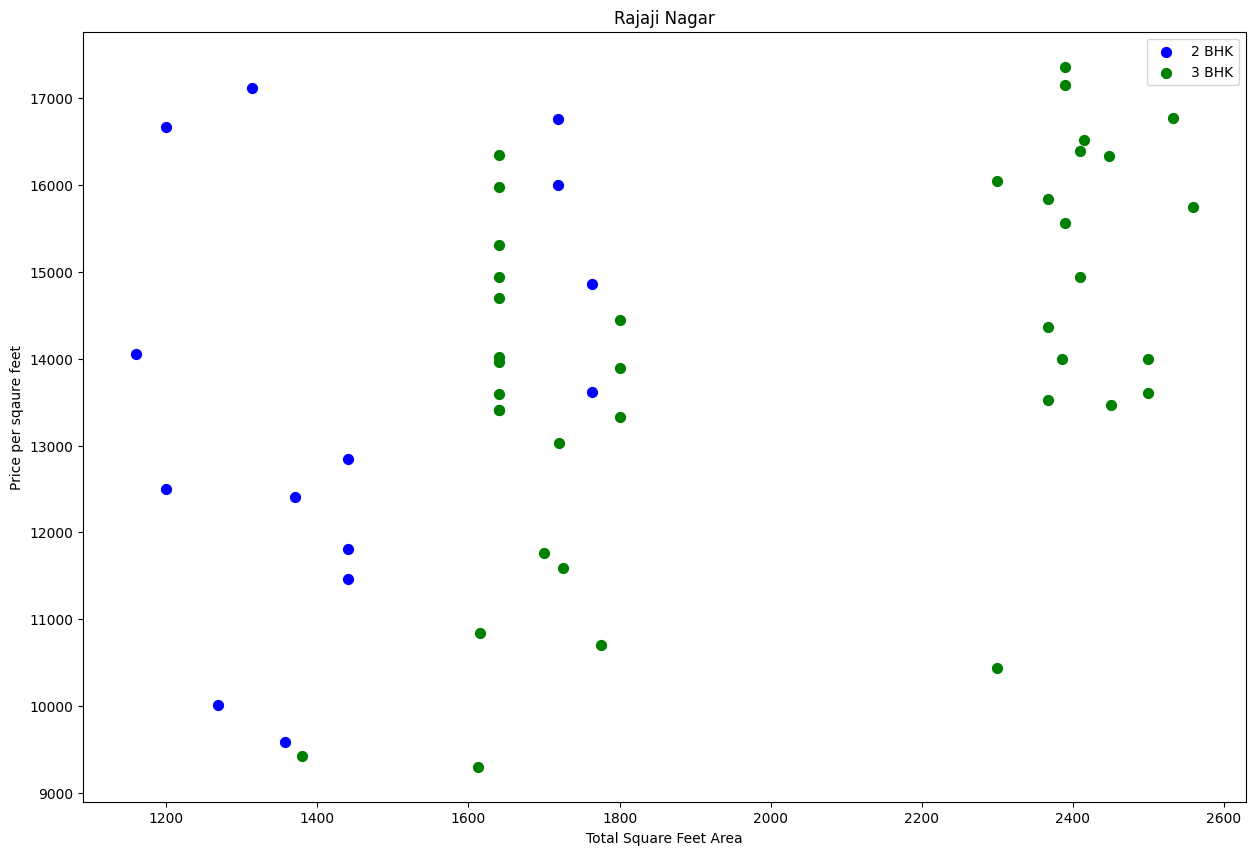

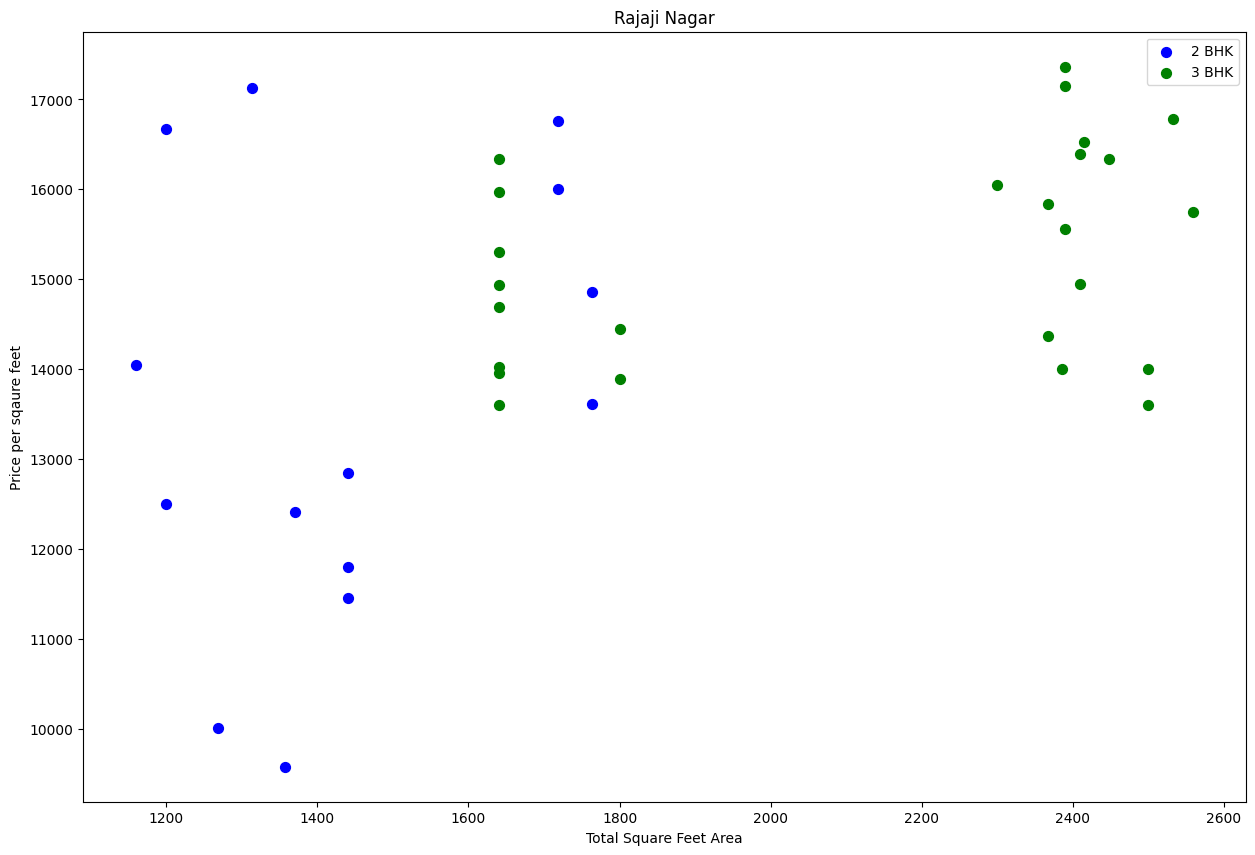

In [6]:
# outlier removal
# Assuming typical sqft per bedroom = at least 300
df3.shape
df3[df3.total_sqft/df3.bhk < 300].head()
df4 = df3[~(df3.total_sqft/df3.bhk < 300)]
df4.shape
# Removed around 1000+ outliers

# min=267.829813, max=176470.588235 (outliers, even if it could be because different locations)
df4.price_per_sqft.describe()
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby("location"):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        # just keeps those within mean +- std
        reduced_df = subdf[(subdf.price_per_sqft>(m-st))&(subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out, reduced_df], ignore_index=True)
    return df_out

df5 = remove_pps_outliers(df4)
df5.shape # 12502 -> 10241, 1000+ outliers removed


def plot_scatter_chart(df, location):
    bhk2 = df[(df.location==location) & (df.bhk == 2)]
    bhk3 = df[(df.location==location) & (df.bhk == 3)]
    plt.figure(figsize=(15,10))
    plt.scatter(bhk2.total_sqft, bhk2.price_per_sqft,color="blue", label="2 BHK", s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price_per_sqft,color="green", label="3 BHK", s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price per sqaure feet")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df5, "Rajaji Nagar")

# Less bedrooms should have lower price: remove those blue points(2 bedrooms) above green points(3 bedrooms) on same line
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby("location"):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby("bhk"):
            bhk_stats[bhk] = {
                "mean": np.mean(bhk_df.price_per_sqft),
                "std": np.std(bhk_df.price_per_sqft),
                "count": bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby("bhk"):
            stats = bhk_stats.get(bhk - 1)
            if stats and stats["count"] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < stats["mean"]].index.values)
    return df.drop(exclude_indices, axis="index")

df6 = remove_bhk_outliers(df5)
df6.shape

# Observe the difference
plot_scatter_chart(df6, "Rajaji Nagar") 

In [7]:
# Unusual to have too many bathroom
df6.bath.unique()
df6[df6.bath > 10]

df7 = df6[df6.bath < df6.bhk + 2]
df7 = df7.drop(["size", "price_per_sqft"], axis="columns")
df7.shape


(7251, 5)

### Model Building

In [8]:
# One-hot encoding
dummies = pd.get_dummies(df7.location).astype(int)

df8 = pd.concat([df7, dummies.drop(["other"], axis="columns")], axis="columns")
df9 = df8.drop("location",  axis="columns")
df9.shape

# independent variables
X = df9.drop("price",  axis="columns")
# dependent variables
y = df9.price

# training and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# Model training (You should try other regression methods as well)
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train, y_train)
lr_clf.score(X_test, y_test)

# K-Fold validation
from sklearn.model_selection import ShuffleSplit, cross_val_score
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.87461601, 0.81773925, 0.87765704, 0.85082205, 0.81022729])

### Find best model using GridSearchCV


In [9]:
# Shortcut: to find the best regression model with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        "linear_regression": {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False],
                'positive': [True, False]
                }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config["model"], config["params"], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            "model": algo_name,
            "best_score" : gs.best_score_,
            "best_params" : gs.best_params_
        })

    return pd.DataFrame(scores, columns=["model", "best_score", "best_params"])


find_best_model_using_gridsearchcv(X,y)


c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\base.py", line 

,model,best_score,best_params
0,linear_regression,0.846261,"{'fit_intercept': False, 'positive': False}"
1,lasso,0.707131,"{'alpha': 2, 'selection': 'cyclic'}"
2,decision_tree,0.687878,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [10]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

print(predict_price('1st Phase JP Nagar',1000, 2, 2))
print(predict_price('1st Phase JP Nagar',1000, 3, 3))



93.16334356381634
90.91978763648711


c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Wong Hui Ying\Documents\ML\KneeOA\venv-3.12\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Export the model to pickle file

In [11]:
import pickle

# Just models with parameters (no actual data)
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

# Export data columns (for prediction)
import json
columns = {
    "data_columns": [col.lower() for col in X.columns]
}
with open('columns.json','w') as f:
    f.write(json.dumps(columns))


### Deploy Flask Server


In [12]:
# TBC in Flask project